# Callin Switzer
Read in all csv files from individual trials, and 
combine into a single long dataset

Updated 4 Dec, 2017


In [451]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import os
import pandas as pd
import time
import re
from datetime import datetime
import sys
import csv
import seaborn as sns
from collections import Counter

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

print(sys.version)

3.6.1 |Anaconda custom (64-bit)| (default, May 11 2017, 13:04:09) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


In [2]:
# define directories
baseDir = os.getcwd()
dataDir = '/Users/cswitzer/Dropbox/SonicationBehavior/SonBehData/SonicationBehaviorTrials_NoImages/'


In [3]:
os.chdir(dataDir)

In [4]:
fldrs = [f for f in os.listdir(".") if not f.startswith('.')]
len(fldrs) # should be 232

232

In [5]:
fldrs.sort(key=lambda x: os.path.getmtime(x)) # sort by time created

In [6]:
# write list of all trials
with open("/Users/cswitzer/Dropbox/SonicationBehavior/SonBehData/RawDataFilenames.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(np.transpose(np.array([fldrs])))

In [7]:
os.chdir(dataDir)

In [8]:
# for each folder, open it, and read the ampFreq.txt file

folders = fldrs

NoFlightFolder = "/Users/cswitzer/Dropbox/SonicationBehavior/SonBehData/SonicationBehaviorData_FlightsRemoved/"

probs = 0
for ii in range(len(folders)):

    # read contents of each folder
    fcontents = [f for f in os.listdir(folders[ii]) if not f.startswith('.')]

    # get ampFreq file(s). there should be one per folder
    ampFreqFile = [x for x in fcontents if 'ampFreq.txt' in x]

    if len(ampFreqFile) > 1: 
        print("PROBLEM " + str(ii))


    # read ampFreq file
    tmpDF = pd.read_table(os.path.join(folders[ii], ampFreqFile[0]), header = None, sep = ',')

    # add folder name to data frame
    tmpDF[7] = folders[ii]

    # add frequency information
    folderInFolder = [x for x in fcontents if not 'ampFreq.txt' in x]

    if len(folderInFolder) > 1: 
        print("PROBLEM")
        probs += 1

    # list files in inner folder
    accRecFiles = [x for x in os.listdir(os.path.join(folders[ii], folderInFolder[0])) if not x.startswith('.')]
    accRecFiles.sort()

    tmpDF[8] = accRecFiles

    # remove wingbeats
    tmpDF2 = tmpDF.loc[(tmpDF[0] > 220) & (tmpDF[0] < 450)]

    # renumber index
    tmpDF2.index = (np.arange(1, tmpDF2.shape[0] + 1))

    # write to .csv
    tmpDF2.to_csv(NoFlightFolder + folders[ii] + '.csv', 
                 header = False, index = True)
    
    if np.mod(ii, 10) == 0:
        print(ii)
    
print(str(probs) + " problems")

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
0 problems


In [9]:
## combine csv's all into a single file
csvDir = NoFlightFolder

csvFiles = [f for f in os.listdir(csvDir) if f.endswith('.csv')]

np_array_list = []
for file_ in csvFiles:
    df = pd.read_csv(os.path.join(csvDir, file_),index_col=None, header=None)
    np_array_list.append(df.as_matrix())

comb_np_array = np.vstack(np_array_list)
big_frame = pd.DataFrame(comb_np_array)

big_frame.columns = ['index', 'freq', 'amp', 'datetime', 'rewNum', 'rewTF', 'lowRewAmp', 'highrewAmp', 'BeeNumCol', 'accFile']

big_frame.head()

,index,freq,amp,datetime,rewNum,rewTF,lowRewAmp,highrewAmp,BeeNumCol,accFile
0,1,340,0.69799,2016_12_11__14_51_35_856,1,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_35_856_220_450_test.txt
1,2,290,0.31249,2016_12_11__14_51_37_400,2,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_37_400_220_450_test.txt
2,3,310,0.49291,2016_12_11__14_51_38_788,3,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_38_788_220_450_test.txt
3,4,310,0.55911,2016_12_11__14_51_39_641,4,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_39_641_220_450_test.txt
4,5,350,0.30275,2016_12_11__14_51_41_043,5,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_41_043_220_450_test.txt


In [10]:
big_frame["freq"].shape

(26552,)

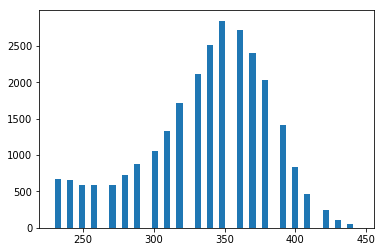

In [11]:
# plot histogram of frequencies
vls = [int(big_frame["freq"][ii]) for ii in range(len(big_frame))]
plt.hist(vls, bins = 50)
plt.show()

In [12]:
# check to see if datetime and accFile agree
eqs = [big_frame['datetime'][ii][1:25] == big_frame['accFile'][ii][0:24] for ii in range(len(big_frame['datetime']))]

In [13]:
np.sum(np.invert(eqs)) # should be zero if all of them match

0

In [14]:
# find the one that doesn't match
big_frame.loc[np.invert(eqs)] # now they all match

,index,freq,amp,datetime,rewNum,rewTF,lowRewAmp,highrewAmp,BeeNumCol,accFile


### make a new column for bee color, hive, reward frequency, date, and treatment (initial, high, low)



In [106]:
str2 = [big_frame['BeeNumCol'][ii].split("Bee")[1] for ii in range(len(big_frame['BeeNumCol']))]

In [107]:
beeColNum = [str2[ii].split(r'_')[0] for ii in range(len(str2))]

In [108]:
hiveNum = [str2[ii].split(r'_')[2] for ii in range(len(str2))]

In [134]:
hive = [int(re.findall(r'\d+', ii)[0]) for ii in hiveNum]

In [146]:
# definition for extracting trial number
def extractNum(string):
    try: 
        aa =  re.findall(r'\d+', string)[0]
    except:
        aa = "1"
    return(int(aa))
    

In [148]:
# get trial number
trialNum = [extractNum(ii) for ii in beeColNum]

In [150]:
# function to get only characters
def extractChar(string):
    return(" ".join(re.findall("[a-zA-Z]+", string)))

In [151]:
# get just bee color
beeCol = [extractChar(strg) for strg in beeColNum]

In [152]:
# get datetime
dateTime = [datetime.strptime(dt1, ' %Y_%m_%d__%H_%M_%S_%f') for dt1 in big_frame['datetime']]

In [153]:
# string format time
dateTime_format = [datetime.strftime(datetime_object, "%Y-%m-%d %H:%M:%S.%f") for datetime_object in dateTime]

In [154]:
# get reward frequencies
s1 = big_frame['accFile'][0]

In [280]:
rewFrqs = [s1.split("_")[8:10] for s1 in big_frame['accFile']]


In [282]:
rewDF = pd.DataFrame(rewFrqs, columns = ['lowFrq', 'highFrq'])

# make sure all reward frequencies are integers
rewFrqs = [[int(float(jj)) for jj in ff] for ff in rewFrqs]

In [284]:
# add to big data frame
big_frame['hive'] = hive
big_frame['trialNum'] = trialNum
big_frame['beeCol'] = beeCol
big_frame['beeCol'] = big_frame['beeCol'].str.lower()
big_frame['datetime_str'] = dateTime_format

In [286]:
big_frame2 = pd.concat([big_frame, rewDF], axis  = 1)

big_frame2.head()

,index,freq,amp,datetime,rewNum,rewTF,lowRewAmp,highrewAmp,BeeNumCol,accFile,trialNum,beeCol,datetime_str,hive,lowFrq,highFrq
0,1,340,0.69799,2016_12_11__14_51_35_856,1,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_35_856_220_450_test.txt,1,silver,2016-12-11 14:51:35.856000,5,220,450
1,2,290,0.31249,2016_12_11__14_51_37_400,2,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_37_400_220_450_test.txt,1,silver,2016-12-11 14:51:37.400000,5,220,450
2,3,310,0.49291,2016_12_11__14_51_38_788,3,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_38_788_220_450_test.txt,1,silver,2016-12-11 14:51:38.788000,5,220,450
3,4,310,0.55911,2016_12_11__14_51_39_641,4,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_39_641_220_450_test.txt,1,silver,2016-12-11 14:51:39.641000,5,220,450
4,5,350,0.30275,2016_12_11__14_51_41_043,5,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_41_043_220_450_test.txt,1,silver,2016-12-11 14:51:41.043000,5,220,450


In [287]:
# remove test rows
big_frame2 = big_frame2.loc[big_frame2['beeCol'] != "testtestphoto",:]

In [288]:
# fix typo -- accidentally wrote "whitred" instead of whitered
big_frame2["beeCol"] = big_frame2["beeCol"].replace("whitred", "whitered")

In [289]:
big_frame2.to_csv('/Users/cswitzer/Dropbox/SonicationBehavior/SonBehData/CombinedBeeTrials_noWingbeats.csv', header = True, index = False)

## Incorporate IT-Span Information

In [32]:
%qtconsole

In [290]:
dataDir2 = '/Users/cswitzer/Dropbox/SonicationBehavior/SonBehData/BeeMetaData/'

In [291]:
## Add IT Span to dataset
md = pd.read_csv(dataDir2 + "BeeMetaData1.csv")
print(md.shape)
md2 = pd.read_csv(dataDir2 + "BeeMetaData2.csv")
print(md2.shape)

(218, 19)
(12, 21)


In [292]:
md_comb = pd.concat([md, md2])
md_comb.shape

(230, 26)

In [293]:
md_comb= md_comb[pd.notnull(md_comb['IT'])]
md_comb.shape

(42, 26)

In [294]:
md_sub = md_comb.loc[:, ['BeeColorNum', 'IT', 'Hive']]
md_sub = md_sub.reset_index(drop=True)
md_sub['Hive'] = md_sub['Hive'].astype(int)
md_sub

,BeeColorNum,IT,Hive
0,pink,4.86,4
1,gold,4.05,3
2,yellow,3.74,4
3,blue,3.61,4
4,redblue,3.75,4
5,purple,3.99,3
6,whitegreen,4.00,4
7,whitepurple,4.45,5
8,white,4.03,4
9,goldred,3.01,4


In [295]:
# check to make sure each row is unique
print(len(md_sub))
print(len(np.unique(md_sub['BeeColorNum'])))

42
42


### Merge metadata into full dataset



In [418]:
bf2 = big_frame2.merge(md_sub, left_on =['beeCol', 'hive'], right_on = ["BeeColorNum", "Hive"], how = 'outer', indicator = True)
bf2.head()

,index,freq,amp,datetime,rewNum,rewTF,lowRewAmp,highrewAmp,BeeNumCol,accFile,trialNum,beeCol,datetime_str,hive,lowFrq,highFrq,BeeColorNum,IT,Hive,_merge
0,1,340,0.69799,2016_12_11__14_51_35_856,1,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_35_856_220_450_test.txt,1,silver,2016-12-11 14:51:35.856000,5,220,450,NaN,NaN,NaN,left_only
1,2,290,0.31249,2016_12_11__14_51_37_400,2,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_37_400_220_450_test.txt,1,silver,2016-12-11 14:51:37.400000,5,220,450,NaN,NaN,NaN,left_only
2,3,310,0.49291,2016_12_11__14_51_38_788,3,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_38_788_220_450_test.txt,1,silver,2016-12-11 14:51:38.788000,5,220,450,NaN,NaN,NaN,left_only
3,4,310,0.55911,2016_12_11__14_51_39_641,4,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_39_641_220_450_test.txt,1,silver,2016-12-11 14:51:39.641000,5,220,450,NaN,NaN,NaN,left_only
4,5,350,0.30275,2016_12_11__14_51_41_043,5,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_41_043_220_450_test.txt,1,silver,2016-12-11 14:51:41.043000,5,220,450,NaN,NaN,NaN,left_only


In [419]:
Counter(bf2._merge) # shows 144 rows that don't have IT span metadata

Counter({'both': 26402, 'left_only': 144})

In [420]:
# show rows where IT span is missing
bf2[bf2['_merge'] == "left_only"]

,index,freq,amp,datetime,rewNum,rewTF,lowRewAmp,highrewAmp,BeeNumCol,accFile,trialNum,beeCol,datetime_str,hive,lowFrq,highFrq,BeeColorNum,IT,Hive,_merge
0,1,340,0.69799,2016_12_11__14_51_35_856,1,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_35_856_220_450_test.txt,1,silver,2016-12-11 14:51:35.856000,5,220,450,NaN,NaN,NaN,left_only
1,2,290,0.31249,2016_12_11__14_51_37_400,2,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_37_400_220_450_test.txt,1,silver,2016-12-11 14:51:37.400000,5,220,450,NaN,NaN,NaN,left_only
2,3,310,0.49291,2016_12_11__14_51_38_788,3,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_38_788_220_450_test.txt,1,silver,2016-12-11 14:51:38.788000,5,220,450,NaN,NaN,NaN,left_only
3,4,310,0.55911,2016_12_11__14_51_39_641,4,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_39_641_220_450_test.txt,1,silver,2016-12-11 14:51:39.641000,5,220,450,NaN,NaN,NaN,left_only
4,5,350,0.30275,2016_12_11__14_51_41_043,5,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_41_043_220_450_test.txt,1,silver,2016-12-11 14:51:41.043000,5,220,450,NaN,NaN,NaN,left_only
5,6,310,0.09735,2016_12_11__14_51_41_507,6,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_41_507_220_450_test.txt,1,silver,2016-12-11 14:51:41.507000,5,220,450,NaN,NaN,NaN,left_only
6,7,330,0.28004,2016_12_11__14_51_45_432,7,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_45_432_220_450_test.txt,1,silver,2016-12-11 14:51:45.432000,5,220,450,NaN,NaN,NaN,left_only
7,8,340,0.75283,2016_12_11__14_51_46_219,8,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_46_219_220_450_test.txt,1,silver,2016-12-11 14:51:46.219000,5,220,450,NaN,NaN,NaN,left_only
8,9,320,0.73012,2016_12_11__14_51_46_792,9,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_46_792_220_450_test.txt,1,silver,2016-12-11 14:51:46.792000,5,220,450,NaN,NaN,NaN,left_only
9,10,360,1.12178,2016_12_11__14_51_47_248,10,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_47_248_220_450_test.txt,1,silver,2016-12-11 14:51:47.248000,5,220,450,NaN,NaN,NaN,left_only


In [421]:
np.unique(bf2[bf2['_merge'] == "left_only"]["beeCol"])

array(['green', 'orange', 'silver'], dtype=object)

In [422]:
# make sure hive matches, except for the missing bees -- should be 144
np.sum(bf2["Hive"] != bf2["hive"])

144

In [423]:
# show all the possible treatments done in the experiments
bf2.groupby(['lowFrq','highFrq']).size().reset_index().rename(columns={0:'count'})

,lowFrq,highFrq,count
0,220,330,12703
1,220,350,210
2,220,450,5106
3,338,388,6534
4,350,450,30
5,395,450,460
6,500,500,1503


In [424]:
# add treatment to dataset
trt = []
for ii in range(len(bf2)):
    low = int(float(bf2.lowFrq[ii]))
    high = int(float(bf2.highFrq[ii]))
    if((low == 220)  & (high == 450)):
        trt.append('full')
    elif(low == 500):
        trt.append('unrewarded')
    elif(low > 250):
        trt.append('high')
    elif(low < 250 & high <= 350):
        trt.append('low')
    else:
        trt.append('unknown')
print(len(trt))
print(len(trt) == len(bf2))

26546
True


In [425]:
bf2['trt'] = trt

In [426]:
bf2.head()

,index,freq,amp,datetime,rewNum,rewTF,lowRewAmp,highrewAmp,BeeNumCol,accFile,...,beeCol,datetime_str,hive,lowFrq,highFrq,BeeColorNum,IT,Hive,_merge,trt
0,1,340,0.69799,2016_12_11__14_51_35_856,1,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_35_856_220_450_test.txt,...,silver,2016-12-11 14:51:35.856000,5,220,450,NaN,NaN,NaN,left_only,full
1,2,290,0.31249,2016_12_11__14_51_37_400,2,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_37_400_220_450_test.txt,...,silver,2016-12-11 14:51:37.400000,5,220,450,NaN,NaN,NaN,left_only,full
2,3,310,0.49291,2016_12_11__14_51_38_788,3,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_38_788_220_450_test.txt,...,silver,2016-12-11 14:51:38.788000,5,220,450,NaN,NaN,NaN,left_only,full
3,4,310,0.55911,2016_12_11__14_51_39_641,4,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_39_641_220_450_test.txt,...,silver,2016-12-11 14:51:39.641000,5,220,450,NaN,NaN,NaN,left_only,full
4,5,350,0.30275,2016_12_11__14_51_41_043,5,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_41_043_220_450_test.txt,...,silver,2016-12-11 14:51:41.043000,5,220,450,NaN,NaN,NaN,left_only,full


In [427]:
# save to .csv file
bf2.to_csv('/Users/cswitzer/Dropbox/SonicationBehavior/SonBehData/CombinedBeeTrials_noWingbeats.csv', header = True, index = False)

In [428]:
# impute missing IT spans for 144 rows
smdf = bf2.loc[bf2['trt'] == 'full', :]
len(smdf)

5106

In [429]:
smdf = smdf.reset_index(drop=True)
smdf.head()

,index,freq,amp,datetime,rewNum,rewTF,lowRewAmp,highrewAmp,BeeNumCol,accFile,...,beeCol,datetime_str,hive,lowFrq,highFrq,BeeColorNum,IT,Hive,_merge,trt
0,1,340,0.69799,2016_12_11__14_51_35_856,1,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_35_856_220_450_test.txt,...,silver,2016-12-11 14:51:35.856000,5,220,450,NaN,NaN,NaN,left_only,full
1,2,290,0.31249,2016_12_11__14_51_37_400,2,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_37_400_220_450_test.txt,...,silver,2016-12-11 14:51:37.400000,5,220,450,NaN,NaN,NaN,left_only,full
2,3,310,0.49291,2016_12_11__14_51_38_788,3,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_38_788_220_450_test.txt,...,silver,2016-12-11 14:51:38.788000,5,220,450,NaN,NaN,NaN,left_only,full
3,4,310,0.55911,2016_12_11__14_51_39_641,4,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_39_641_220_450_test.txt,...,silver,2016-12-11 14:51:39.641000,5,220,450,NaN,NaN,NaN,left_only,full
4,5,350,0.30275,2016_12_11__14_51_41_043,5,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_41_043_220_450_test.txt,...,silver,2016-12-11 14:51:41.043000,5,220,450,NaN,NaN,NaN,left_only,full


In [430]:
smdf['freq'] = [int(smdf.loc[ii, 'freq']) for ii in range(len(smdf))]

In [455]:
indBees = pd.DataFrame(smdf.groupby(['beeCol', 'hive'], as_index=False)['freq'].mean())
print(len(indBees))
indBees.head()

43


,beeCol,hive,freq
0,blue,4,395.277778
1,gold,3,348.333333
2,goldred,4,406.666667
3,green,4,308.461538
4,lime,5,374.642857


In [456]:
# get bee frequencies (excluding the missing bees)
indFreqs = pd.DataFrame(smdf.groupby(['beeCol', 'hive', 'IT'], as_index=False)['freq'].mean())
print(len(indFreqs))
indFreqs.head()

40


,beeCol,hive,IT,freq
0,blue,4,3.61,395.277778
1,gold,3,4.05,348.333333
2,goldred,4,3.01,406.666667
3,lime,5,4.02,374.642857
4,limeblue,5,4.69,304.150943


In [507]:
# merge datasets
beeFreq = indBees.merge(indFreqs, how = 'outer', indicator = True)
print(len(beeFreq))
beeFreq.head()

43


,beeCol,hive,freq,IT,_merge
0,blue,4,395.277778,3.61,both
1,gold,3,348.333333,4.05,both
2,goldred,4,406.666667,3.01,both
3,green,4,308.461538,NaN,left_only
4,lime,5,374.642857,4.02,both


In [475]:
# use linear regression to estimate relationship between avg freq and IT span

# Use only one feature
freq_X_train = np.array(indFreqs.loc[:,"freq"]).reshape(-1,1)
freq_X_test = np.array(beeFreq.loc[beeFreq["_merge"] == 'left_only', "freq"]).reshape(-1,1)

# response variable
freq_y_train = np.array(indFreqs.loc[:, "IT"]).reshape(-1,1)


# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(freq_X_train, freq_y_train)

# Make predictions using the testing set
freq_y_pred = regr.predict(freq_X_test)
freq_y_pred

array([[ 4.20686499],
       [ 3.98649082],
       [ 4.22537315]])

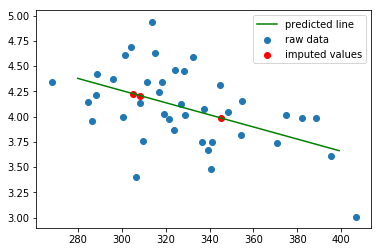

In [493]:


train = plt.scatter(freq_X_train, freq_y_train, label = "raw data")
lne = np.arange(280, 400).reshape(-1,1)
pred, = plt.plot(lne, regr.predict(lne), color = 'green', label='predicted line')
imputedVals = plt.scatter(freq_X_test, freq_y_pred, color = 'r', label = "imputed values")

plt.legend(handles=[pred, train, imputedVals])
plt.show()

###  Put imputed values back into dataset


In [519]:
naSet = beeFreq.loc[beeFreq["_merge"] == 'left_only', :].copy()
naSet["IT"]= freq_y_pred
naSet
# naSet = naSet.drop(["_merge", 'freq', 'index'], axis = 1)
# naSet

,beeCol,hive,freq,IT,_merge
3,green,4,308.461538,4.206865,left_only
17,orange,5,345.098039,3.986491,left_only
27,silver,5,305.384615,4.225373,left_only


In [526]:
beeFreq2 = beeFreq.combine_first(naSet)
beeFreq2 = beeFreq2.drop(["freq", "_merge"], axis = 1)
beeFreq2.head()

,beeCol,hive,IT
0,blue,4,3.610000
1,gold,3,4.050000
2,goldred,4,3.010000
3,green,4,4.206865
4,lime,5,4.020000


In [529]:
bf2.head()

,index,freq,amp,datetime,rewNum,rewTF,lowRewAmp,highrewAmp,BeeNumCol,accFile,...,beeCol,datetime_str,hive,lowFrq,highFrq,BeeColorNum,IT,Hive,_merge,trt
0,1,340,0.69799,2016_12_11__14_51_35_856,1,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_35_856_220_450_test.txt,...,silver,2016-12-11 14:51:35.856000,5,220,450,NaN,NaN,NaN,left_only,full
1,2,290,0.31249,2016_12_11__14_51_37_400,2,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_37_400_220_450_test.txt,...,silver,2016-12-11 14:51:37.400000,5,220,450,NaN,NaN,NaN,left_only,full
2,3,310,0.49291,2016_12_11__14_51_38_788,3,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_38_788_220_450_test.txt,...,silver,2016-12-11 14:51:38.788000,5,220,450,NaN,NaN,NaN,left_only,full
3,4,310,0.55911,2016_12_11__14_51_39_641,4,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_39_641_220_450_test.txt,...,silver,2016-12-11 14:51:39.641000,5,220,450,NaN,NaN,NaN,left_only,full
4,5,350,0.30275,2016_12_11__14_51_41_043,5,T,0,5,Beesilver1_11Dec2016_Hive5_initial,2016_12_11__14_51_41_043_220_450_test.txt,...,silver,2016-12-11 14:51:41.043000,5,220,450,NaN,NaN,NaN,left_only,full


In [533]:
# merge

bf3 = bf2.combine_first(beeFreq2)
bf3.head()

,BeeColorNum,BeeNumCol,Hive,IT,_merge,accFile,amp,beeCol,datetime,datetime_str,...,highFrq,highrewAmp,hive,index,lowFrq,lowRewAmp,rewNum,rewTF,trialNum,trt
0,NaN,Beesilver1_11Dec2016_Hive5_initial,NaN,3.610000,left_only,2016_12_11__14_51_35_856_220_450_test.txt,0.69799,silver,2016_12_11__14_51_35_856,2016-12-11 14:51:35.856000,...,450,5,5,1,220,0,1,T,1,full
1,NaN,Beesilver1_11Dec2016_Hive5_initial,NaN,4.050000,left_only,2016_12_11__14_51_37_400_220_450_test.txt,0.31249,silver,2016_12_11__14_51_37_400,2016-12-11 14:51:37.400000,...,450,5,5,2,220,0,2,T,1,full
2,NaN,Beesilver1_11Dec2016_Hive5_initial,NaN,3.010000,left_only,2016_12_11__14_51_38_788_220_450_test.txt,0.49291,silver,2016_12_11__14_51_38_788,2016-12-11 14:51:38.788000,...,450,5,5,3,220,0,3,T,1,full
3,NaN,Beesilver1_11Dec2016_Hive5_initial,NaN,4.206865,left_only,2016_12_11__14_51_39_641_220_450_test.txt,0.55911,silver,2016_12_11__14_51_39_641,2016-12-11 14:51:39.641000,...,450,5,5,4,220,0,4,T,1,full
4,NaN,Beesilver1_11Dec2016_Hive5_initial,NaN,4.020000,left_only,2016_12_11__14_51_41_043_220_450_test.txt,0.30275,silver,2016_12_11__14_51_41_043,2016-12-11 14:51:41.043000,...,450,5,5,5,220,0,5,T,1,full


In [29]:
# print system info
import IPython
print(IPython.sys_info())

{'commit_hash': '5a894b9',
 'commit_source': 'installation',
 'default_encoding': 'UTF-8',
 'ipython_path': '/Users/cswitzer/anaconda/envs/python3/lib/python3.6/site-packages/IPython',
 'ipython_version': '5.3.0',
 'os_name': 'posix',
 'platform': 'Darwin-17.2.0-x86_64-i386-64bit',
 'sys_executable': '/Users/cswitzer/anaconda/envs/python3/bin/python',
 'sys_platform': 'darwin',
 'sys_version': '3.6.1 |Anaconda custom (64-bit)| (default, May 11 2017, '
                '13:04:09) \n'
                '[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]'}


In [30]:
# show installed packages and versions
!pip freeze 

alabaster==0.7.10
anaconda-client==1.6.3
anaconda-navigator==1.6.2
anaconda-project==0.6.0
appnope==0.1.0
appscript==1.0.1
asn1crypto==0.22.0
astroid==1.4.9
astropy==1.3.2
Babel==2.4.0
backports.functools-lru-cache==1.4
backports.shutil-get-terminal-size==1.0.0
beautifulsoup4==4.6.0
bitarray==0.8.1
blaze==0.10.1
bleach==1.5.0
bokeh==0.12.5
boto==2.46.1
Bottleneck==1.2.1
cffi==1.10.0
chardet==3.0.3
click==6.7
cloudpickle==0.2.2
clyent==1.2.2
colorama==0.3.9
conda==4.3.30
contextlib2==0.5.5
cryptography==1.8.1
cycler==0.10.0
Cython==0.25.2
cytoolz==0.8.2
dask==0.14.3
datashape==0.5.4
decorator==4.0.11
distributed==1.16.3
docutils==0.13.1
entrypoints==0.2.2
et-xmlfile==1.0.1
fastcache==1.0.2
Flask==0.12.2
Flask-Cors==3.0.2
gevent==1.2.1
greenlet==0.4.12
h5py==2.7.1
HeapDict==1.0.0
html5lib==0.999
idna==2.5
imagesize==0.7.1
ipykernel==4.6.1
ipython==5.3.0
ipython-genutils==0.2.0
ipywidgets==6.0.0
isort==4.2.5
itsdangerous==0.24
jdcal==1.3
jedi==0.10.2
Jinja2==2.9.6
jsonschema==2.6.0
jupyte

In [31]:
# convert to html, so ppl don't have to run python to see code
os.chdir(baseDir)
!jupyter nbconvert --to html 001_CombineTrialsIntoLongCSV

[NbConvertApp] Converting notebook 001_CombineTrialsIntoLongCSV.ipynb to html
[NbConvertApp] Writing 303003 bytes to 001_CombineTrialsIntoLongCSV.html
